# Regime-Aware Least Squares

<div class="alert alert-block alert-warning"> <b>Disclaimer</b> This notebook is for illustrative purposes only, and is still work in progress. </div>

### Summary & Objectives
The regime-aware least squares methodology presented in this notebook leverages the regime framework behind the Hidden Markov model (HMM) to estimate regime-dependent betas, and combine them accordingly to arribe at dynamic betas. These estimates are be forward looking in nature, reflecting both the current regime and the probabilities of transitioning into other regimes in the future.   

The purpose of this notebook is to layout the math behind the aforementioned methodology, and present and example.

In [1]:
from datetime import datetime
from hmmlearn.hmm import GaussianHMM
import pandas as pd
import numpy as np
import os
from scipy.linalg import block_diag
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import warnings
import matplotlib.ticker as mtick
# warnings.simplefilter('ignore')

fldr = os.path.abspath(os.path.join(os.getcwd(), '..'))
start_dt = datetime(1926, 12, 31) 
end_dt = datetime(2020, 3, 31)
freq = 'W'
aesthetic_labels = {'mktrf': 'Mkt-Rf', 'smb': 'SmB', 'hml': 'HmL'}

### Data
For this exercise we will use the weekly returns published for the market risk (Mkt-RF), size (SmB), and value (HmL) factors, available on the Ken French's data library. The company used in this example is Coca-Cola, and was chosen because of his long history, starting in 1926 (same as the factors).

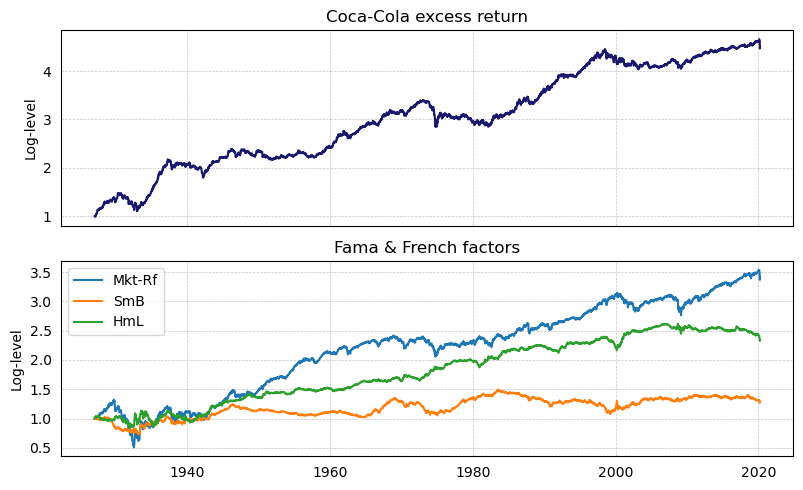

In [2]:
# Fama-French factors
rt_ff = pd.read_pickle(f'{fldr}/data/ff.pkl')
rt_ff = rt_ff.add(1).groupby(pd.Grouper(freq=freq)).prod().sub(1)
rt_ff = rt_ff.loc[start_dt:end_dt]

# Stock returns (Coca-cola's permno: 11308)
rt = pd.read_pickle(f'{fldr}/data/rt_sp.pkl').loc[start_dt:end_dt, 11308]
rt = rt.add(1).groupby(pd.Grouper(freq=freq)).prod().sub(1)
er = rt - rt_ff['rf']
er = er.reindex(rt_ff.index)

# Visualizing the dataset
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, sharex=True)
axs[0].plot(er.add(1).cumprod().mul(10).apply(np.log10), c='midnightblue')
axs[1].plot(rt_ff[['mktrf', 'smb', 'hml']].add(1).cumprod().mul(10).apply(np.log10))
for i in range(2):
    axs[i].grid(ls='--', lw=.5, alpha=.75, zorder=-25)
    axs[i].set_ylabel('Log-level')
    axs[i].tick_params(bottom=False, left=False)

axs[0].set_title('Coca-Cola excess return')
axs[1].set_title('Fama & French factors')
axs[1].legend(['Mkt-Rf', 'SmB', 'HmL'])
plt.tight_layout()

### Regime Modeling
#### Calibrating the number of regimes
In order to fit a HMM, we need to provide the number of regimes (gaussian mixtures) that the model needs to describe. For this exercise, we set a grid and calculate information criteria for each point on the grid.

Using the entire data set, we fit the model with different numbers of regimes. After testing iteratively from 2 till 10 regimes, the BIC indicates that 3 hidden states might be enough to describe the dynamics of the three factors. It is worth mentioning that the optimal number of states to be found will depend on the frequency of sample, its length and time periods included. For this reason, the optimal number of regimes might be different in future implementations. 

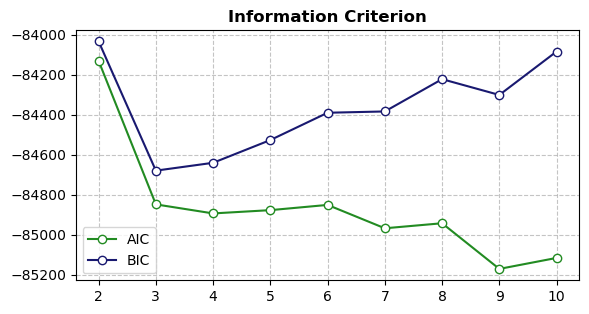

In [3]:
trn = rt_ff[['mktrf', 'smb', 'hml']]  # Training set
X = trn.values

states_to_try = range(2, 11)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
for n in states_to_try:
    mdl = GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
    mdl.fit(X)
    bic[n] = mdl.bic(X)
    aic[n] = mdl.aic(X)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])

### Model fitting
Now that we set the number of regimes to be 3, we fit the HMM on the entire sample, using the aforementioned number of mixtures. 

In [4]:
# Model fitting
trn = rt_ff[['mktrf', 'smb', 'hml']]  # Training set
m = 3  # Number of regimes

model = GaussianHMM(n_components=m, covariance_type="diag", n_iter=1000, min_covar=1e-10, algorithm='viterbi', random_state=0)
model.fit(trn)

# Emmission probabilities matrix
Gamma = model.predict_proba(trn)

# Results tables
cols = pd.MultiIndex.from_tuples([('State-dependent means', aesthetic_labels[x]) for x in trn.columns])
table_means = pd.DataFrame(model.means_, columns=cols)
table_means.index.name = 'Hidden State'
display(table_means.mul(52).apply(lambda x: x.map('{:.2%}'.format)))

print('\n')
cols = pd.MultiIndex.from_tuples([('State-dependent volatilities', aesthetic_labels[x]) for x in trn.columns])
table_vols = pd.DataFrame([np.diag(model.covars_[i]) for i in range(m)], columns=cols).apply(np.sqrt)
table_vols.index.name = 'Hidden State'
display(table_vols.mul(np.sqrt(52)).apply(lambda x: x.map('{:.2%}'.format)))

State-dependent means                
                            Mkt-Rf     SmB     HmL
Hidden State                                      
0                           16.77%   3.67%   0.99%
1                          -19.12%  -1.04%  15.35%
2                          -11.18%  -5.14%   8.86%

State-dependent volatilities                
                                   Mkt-Rf     SmB     HmL
Hidden State                                             
0                                  10.29%   6.00%   5.83%
1                                  49.85%  24.84%  30.97%
2                                  20.66%  10.50%  11.98%

The tables above describe the distributions of the three regimes fitted. Interpreting  the economic meaning of each one of these three regimes is outside of the scope of this notebook. However, at a very high level, they seem to be describing bull (0), bear (1), and stressed markets (2). The previous can be further confirmed by the plot below, where states 1 and 2 seem to coincide with economic crises.

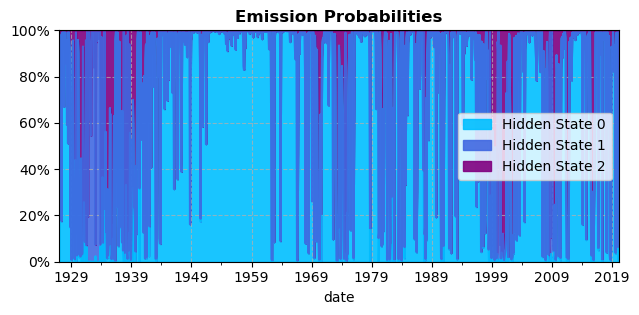

In [5]:
df = pd.DataFrame(Gamma, index=trn.index, columns=[f'Hidden State {x}' for x in range(m)])

fig, ax = plt.subplots(figsize=(6.5, 3.25))
df.resample('M').last().plot.area(stacked=True, ax=ax, alpha=.9, color=['deepskyblue', 'royalblue', 'purple'])
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_title('Emission Probabilities', weight='bold')
ax.set_ylim(0, 1)
ax.axhline(0, c='k', lw=.5, zorder=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.tight_layout()
plt.show()

### Regression Parameter Estimation

Before implementing our methodology on Coca-Cola's excess returns, we fit OLS on the same sample, to have it as a point of reference to contrast our regime-aware estimations.

In [6]:
# Full-sample OLS
endog = er
exog = rt_ff.copy()[['mktrf', 'smb', 'hml']]
exog.rename(aesthetic_labels, axis=1, inplace=True)
exog = sm.add_constant(exog)
model_ols = sm.OLS(endog, exog)
results = model_ols.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     704.2
Date:                Thu, 07 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:12:00   Log-Likelihood:                 10915.
No. Observations:                4866   AIC:                        -2.182e+04
Df Residuals:                    4862   BIC:                        -2.180e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.731      0.0

Let's jump back to the regime-aware estimation. Given $\mathcal{F}_{t}$, let

1. $\boldsymbol{S} = \{ S_{1}, S_{2}, \dots, S_{m} \}$ be a finite set of $m$ hidden states of the system;
1. $\boldsymbol{\boldsymbol{Z}} \in \mathbb{R}^{T \times k}$ be the set of historical factor returns;
1. $\boldsymbol{B} \in \mathbb{R}^{m \times m}$ be the set of state-transition probabilities (i.e., the transition matrix);
1. $\boldsymbol{\Gamma} \in \mathbb{R}^{T \times k}$ be the emission probabilities matrix
1. $\boldsymbol{r} \in \mathbb{R}^{T \times 1}$ be the historical excess returns of the stock we want to project our factor estimates onto

In our case, $k$ is 4, as we are dealing with three factors and one constant. From the above, $\boldsymbol{S}$, $\boldsymbol{B}$, and $\boldsymbol{\Gamma}$ are outputted by the HMM fitting. 

The emission probabilities matrix $\boldsymbol{\Gamma}$ contain the probability that a realization of the factor returns are emitted when the system is in given state along the columns. This matrix is key in the estimationg of the regime-dependent betas.

\begin{align}
    \boldsymbol{\Gamma}=\begin{bmatrix} 
    \gamma_{1, t - T}  & \gamma_{2, t - T} & \dots & \gamma_{m, t - T} \\
    \vdots & \vdots & \ddots & \vdots \\
    \gamma_{1, t - 1}  & \gamma_{2, t - 1} & \dots & \gamma_{m, t - 1 }\\
    \gamma_{1, t}  & \gamma_{2, t} & \dots & \gamma_{m, t} \\
    \end{bmatrix}_{T \times m}
\end{align}

The framwork requires the calculation of a couple of auxiliary matrices that help combining all the emission probabilities and arrive at a one set of parameter for each of the $m$ hidedn states in the system. Let 
\begin{align}
    \boldsymbol{M} \in \mathbb{R}^{mT \times mk} &:= \boldsymbol{Z} \oplus \boldsymbol{Z} \oplus \dots \oplus \boldsymbol{Z} \\[8pt]
    \boldsymbol{\delta} \in \mathbb{R}^{mT \times m} &:= \boldsymbol{r} \oplus \boldsymbol{r} \oplus \dots \oplus \boldsymbol{r} \\[8pt]
    \boldsymbol{\Omega} \in \mathbb{R}^{mT \times mT} &:= \text{diag} \left( \text{vect} \left(\boldsymbol{\Gamma} \right) \right) \\[8pt]
    \boldsymbol{\mathcal{I}} \in \mathbb{R}^{k \times k m} &:= \begin{bmatrix} I_{k} & I_{k} & \dots & I_{k} \end{bmatrix}   
\end{align}

where $\oplus$ is the direct sum operator, making $\boldsymbol{M}$ and $\boldsymbol{\delta}$ both block matrices that store the information related to historical factors and stock returns, respectively, which is shared between regimes. The block diagonal matrix $\boldsymbol{\Omega}$ rearrages $\boldsymbol{\Gamma}$ so that each block contains the information stored in the columns of the latter as diagonal entries, while $\boldsymbol{\mathcal{I}}$ is used to aggregate the results. Finally, the set of regime-aware regression parameters will be given by 

\begin{align}
\hat{\boldsymbol{\Theta}} &= \boldsymbol{\mathcal{I}} \: \left(\boldsymbol{M}^{T} \boldsymbol{\Omega} \boldsymbol{M}\right)^{-1} \boldsymbol{M}^{T}\boldsymbol{\Omega} \boldsymbol{\delta}
\end{align}

which is a $k \times m$ matrix that contains the exposure of the stock returns in $\boldsymbol{r}$ to each of the $k$ factors (along the rows), in each of the $m$ hidden states (along the columns).

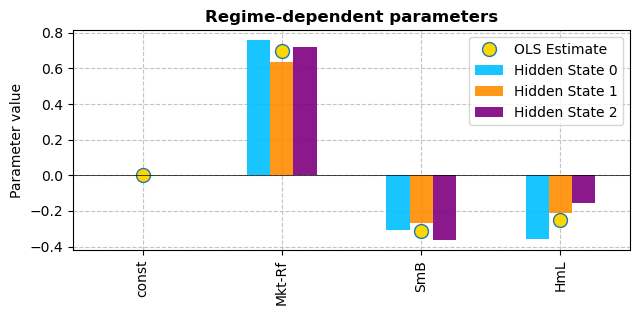

In [7]:
Z = sm.add_constant(trn)  # Exogenous variables
k = Z.shape[1]  # Number of parameters to estimate

M = block_diag(*[Z] * m)
delta = block_diag(*[er.values.reshape(-1, 1)] * m)
Omega = np.diag(Gamma.flatten('F'))
I = np.concatenate([np.eye(k)] * m, axis=1)
Theta = I @ np.linalg.inv(M.T @ Omega @ M) @ M.T @ Omega @ delta  # Regime-dependent betas

# Plotting
table_parameters = pd.DataFrame(Theta, index=Z.columns)
table_parameters.columns = [f'Hidden State {x}' for x in range(m)]
table_parameters.rename(aesthetic_labels, axis=0, inplace=True)
fig, ax = plt.subplots(figsize=(6.5, 3.25))
table_parameters.plot.bar(ax=ax, zorder=10, alpha=.9, color=['deepskyblue', 'darkorange', 'purple'])
ax.plot(results.params, marker='o', ms=10, mfc='gold', ls='')
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_title('Regime-dependent parameters', weight='bold')
ax.set_ylabel('Parameter value')
ax.legend(['OLS Estimate'] + list(table_parameters.columns))
ax.axhline(0, c='k', lw=.5, zorder=15)

plt.tight_layout()
plt.show()

As it can be seen in the figure above, the regime-dependent betas are close to the OLS estimates, but they present slight variations around those estimates, that vary with the regimes.

After these regime-dependent betas are estimates, now we need to combine them to arrive at a single forward-looking set of parameters. For this, we leverage the HMM's transition matrix $\boldsymbol{B}$ and the last row of matrix $\boldsymbol{\Gamma}$, $\boldsymbol{\gamma}_{t}$, which contains the filtered emission probabilities corresponding to the most recent observation.

In [8]:
B = model.transmat_  # Transition matrix

print('Transition matrix:')
display(pd.DataFrame(B, index=[f'Hidden State {x}' for x in range(m)], columns=[f'Hidden State {x}' for x in range(m)]).apply(lambda x: x.map('{:.2%}'.format)))

gamma_t = Gamma[-1, :]  # Filtered emission probabilities (last day in the sample)

print('Emission probabilities at time t (last observation):')
display(pd.Series(gamma_t.flatten(), index=[f'Hidden State {x}' for x in range(m)]).map('{:.2%}'.format))

Transition matrix:


,Hidden State 0,Hidden State 1,Hidden State 2
Hidden State 0,94.82%,0.00%,5.18%
Hidden State 1,0.00%,81.11%,18.89%
Hidden State 2,13.38%,3.82%,82.80%


Emission probabilities at time t (last observation):


Hidden State 0     0.00%
Hidden State 1    99.22%
Hidden State 2     0.78%
dtype: object

Putting everything together we get:

\begin{align}
      \hat{\boldsymbol{\theta}}_{i, t}^{h} = \hat{\boldsymbol{\Theta}} \boldsymbol{B}^{T} \boldsymbol{\gamma}_{t}^{T}
\end{align}

where $\hat{\boldsymbol{\theta}}_{i, t} \in \mathbb{R}^{k \times 1}$ contains the regime-aware forward-looking sensitivity of stock $i$ (Coca-Cola) to the set of $k$ factors.

In [9]:
theta_t = Theta @ B.T @ gamma_t.T

print('Regime-aware parameters at time t')
display(pd.Series(theta_t.flatten(), index=Z.columns).map('{:.4}'.format))

Regime-aware parameters at time t


const    -8.148e-05
mktrf        0.6523
smb         -0.2886
hml         -0.1988
dtype: object

The resulting set of parameters is very close to the regime-dependent betas of hidden state 1, which makes sense, given that the filtered probabilites indice that we are currently 99.22% in regime 1, and the transition matrix points at very sticky regimes.